In [2]:
import numpy as np
import pandas as pd
import random
from ctgan import CTGAN
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import seaborn as sns


#==================================Part 1==============================================================

# 1.1 Create a small seed dataset for CTGAN to learn realistic marginals
def simulate_seed(n=2000, fraud_rate=0.03):
    np.random.seed(42)
    # Time step (hours over 30 days)
    step = np.random.randint(0, 24*30, size=n)
    # Transaction types
    types = ['PAYMENT','TRANSFER','CASH_OUT','DEBIT']
    txn_type = np.random.choice(types, size=n, p=[0.5,0.2,0.2,0.1])
    # Amount (log-normal for skew)
    amount = np.round(np.random.lognormal(8,1.2,size=n), 2)
    # Fraud label rare ~1%
    isFraud = np.random.choice([0,1], size=n, p=[1-fraud_rate, fraud_rate])
    # Origin & destination IDs
    nameOrig = [f"O{1000+i}" for i in range(n)]
    nameDest = [f"D{2000+i}" for i in range(n)]
    # Balances before/after
    old_o = np.round(np.random.uniform(100,50000,size=n),2)
    new_o = np.where(isFraud==0, old_o - amount, old_o)
    old_d = np.round(np.random.uniform(0,100000,size=n),2)
    new_d = np.where(isFraud==0, old_d + amount, old_d)
    return pd.DataFrame({
        'step': step,
        'type': txn_type,
        'amount': amount,
        'nameOrig': nameOrig,
        'oldbalanceOrg': old_o,
        'newbalanceOrig': new_o,
        'nameDest': nameDest,
        'oldbalanceDest': old_d,
        'newbalanceDest': new_d,
        'isFraud': isFraud
    })

seed_df = simulate_seed()


#==================================Part 2==============================================================

# Train CTGAN on the seed dataset
cat_cols = ['type','nameOrig','nameDest']
ctgan = CTGAN(epochs=50, batch_size=100)
ctgan.fit(seed_df, discrete_columns=cat_cols)


#==================================Part 3==============================================================

# 1.3 Sample 100,000 synthetic transactions
syn = ctgan.sample(100000)
print("Synthetic shape of generated data using CTGAN:", syn.shape)
print("Fraud rate on the generated Synthetic data:", syn['isFraud'].mean())

Synthetic shape of generated data using CTGAN: (100000, 10)
Fraud rate on the generated Synthetic data: 0.02238


In [3]:
#==================================Part 4==============================================================
from geopy.distance import geodesic

# Assign random lat/lon per account for geolocation rule
loc_o = {acc: (random.uniform(-90,90), random.uniform(-180,180))
         for acc in syn['nameOrig'].unique()}
loc_d = {acc: (random.uniform(-90,90), random.uniform(-180,180))
         for acc in syn['nameDest'].unique()}
syn['locOrig'] = syn['nameOrig'].map(loc_o)
syn['locDest'] = syn['nameDest'].map(loc_d)


#==================================Part 5==============================================================
def apply_rules(df):
    # Initialize flags
    for i in range(1,8):
        df[f'rule{i}']=0
    # History per account
    history = {}
    df.sort_values(['nameOrig','step'], inplace=True)
    for idx,row in df.iterrows():
        acct = row['nameOrig']
        amt, tp, dest, ts = row['amount'], row['type'], row['nameDest'], row['step']
        loc1, loc2 = row['locOrig'], row['locDest']
        if acct not in history:
            history[acct] = {'times':[], 'dests':set(), 'type_amts':{}}
        h = history[acct]
        # 1) Amount Threshold
        if amt>50000: df.at[idx,'rule1']=1
        # 2) Velocity: >5 txns last hour
        recent = [t for t in h['times'] if ts-t<=1]
        if len(recent)>=5: df.at[idx,'rule2']=1
        # 3) Time-of-Day 0-5h
        if (ts%24)<5: df.at[idx,'rule3']=1
        # 4) Type-Amount mismatch
        if (tp=='CASH_OUT' and amt<10) or (tp=='TRANSFER' and amt>80000):
            df.at[idx,'rule4']=1
        # 5) New beneficiary
        if dest not in h['dests']: df.at[idx,'rule5']=1
        # 6) Geolocation >500km
        if geodesic(loc1, loc2).km>500: df.at[idx,'rule6']=1
        # 7) Behavior inconsistency
        lst = h['type_amts'].get(tp,[])
        if len(lst)>=10:
            mu, sd = np.mean(lst), np.std(lst)
            if abs(amt-mu)>3*sd: df.at[idx,'rule7']=1
        # Update history
        h['times'].append(ts)
        h['dests'].add(dest)
        h['type_amts'].setdefault(tp,[]).append(amt)
    # Final flag
    df['isFlaggedFraud'] = df[[f'rule{i}' for i in range(1,8)]].max(axis=1)
    return df

syn = apply_rules(syn)
print(syn[['rule1','rule2','rule3','rule4','rule5','rule6','rule7','isFlaggedFraud']].head())

       rule1  rule2  rule3  rule4  rule5  rule6  rule7  isFlaggedFraud
49867      0      0      0      0      1      1      0               1
32597      0      0      0      0      1      1      0               1
55007      0      0      1      0      1      1      0               1
43424      0      0      0      0      1      1      0               1
89335      0      0      0      0      1      1      0               1


In [4]:
#==================================Part 6==============================================================
# Data Preprocessing

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import joblib

# 6.1 Prepare model dataframe - drop location columns and individual rule columns
model_df = syn.drop(columns=['locOrig','locDest']+[f'rule{i}' for i in range(1,8)])

# 6.2 Encode categorical columns and SAVE the encoders (BUG FIX)
label_encoders = {}
for col in ['type','nameOrig','nameDest']:
    le = LabelEncoder()
    model_df[col] = le.fit_transform(model_df[col])
    label_encoders[col] = le

# Save label encoders for inference
joblib.dump(label_encoders, 'label_encoders.pkl')
print("Label encoders saved to label_encoders.pkl")

# 6.3 Split features/labels - KEEP isFlaggedFraud as a feature (BUG FIX)
X = model_df.drop(columns=['isFraud'])
y = model_df['isFraud']

print("Features used:", X.columns.tolist())

# 6.4 Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 6.5 Scaling - fit ONLY on training data (BUG FIX)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler immediately after fitting on training data
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved to scaler.pkl")

# 6.6 SMOTE on training set
sm = SMOTE(random_state=42)
X_tr_bal, y_tr_bal = sm.fit_resample(X_train_scaled, y_train)
y_tr_bal = y_tr_bal.astype(int)
print("Post-SMOTE fraud rate:", y_tr_bal.mean())

Label encoders saved to label_encoders.pkl
Features used: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']
Scaler saved to scaler.pkl
Post-SMOTE fraud rate: 0.5


In [5]:
#==================================Part 7==============================================================
# Autoencoder - trained only on non-fraud samples
# High reconstruction error indicates anomaly (potential fraud)

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier

# Autoencoder on non-fraud samples only
X_norm = X_tr_bal[y_tr_bal==0]
inp_dim = X_norm.shape[1]

# Architecture: Input -> Encoder -> Bottleneck -> Decoder -> Output
inp = layers.Input(shape=(inp_dim,))
e = layers.Dense(inp_dim//2, activation='relu')(inp)
e = layers.Dense(inp_dim//4, activation='relu')(e)
d = layers.Dense(inp_dim//2, activation='relu')(e)
out = layers.Dense(inp_dim, activation='sigmoid')(d)

ae = models.Model(inp, out)
ae.compile(optimizer='adam', loss='mse')
ae.fit(X_norm, X_norm, epochs=30, batch_size=256, validation_split=0.1, verbose=1)

Epoch 1/30


d:\Git repos\Bank_fraud_detection\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0770 - val_loss: 0.0534
Epoch 2/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0499 - val_loss: 0.0479
Epoch 3/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0459 - val_loss: 0.0442
Epoch 4/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0429 - val_loss: 0.0419
Epoch 5/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0412 - val_loss: 0.0407
Epoch 6/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0404 - val_loss: 0.0401
Epoch 7/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0399 - val_loss: 0.0397
Epoch 8/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0397 - val_loss: 0.0395
Epoch 9/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0395 - val_loss: 0.0393
Epoch 10/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0393 - val_loss: 0.0392
Epoch 11/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0391 - val_loss: 0.0390
Epoch 12/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

In [6]:
#==================================Part 8==============================================================
# Train Random Forest on balanced dataset

X_train_df = pd.DataFrame(X_tr_bal, columns=X.columns)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_df, y_tr_bal)
print("Random Forest trained successfully")

Random Forest trained successfully


In [7]:
#==================================Part 9 & 10==============================================================
# Get predictions from both models

from sklearn.metrics import precision_recall_curve

# RF probabilities
p_rf = rf.predict_proba(X_test_scaled)[:,1]

# AE reconstruction errors -> normalized score
recon = ae.predict(X_test_scaled)
err = np.mean((recon - X_test_scaled)**2, axis=1)
p_ae = (err - err.min()) / (err.max() - err.min())

print("RF predictions shape:", p_rf.shape)
print("AE anomaly scores shape:", p_ae.shape)

d:\Git repos\Bank_fraud_detection\venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
RF predictions shape: (20000,)
AE anomaly scores shape: (20000,)


In [8]:
#==================================Part 11==============================================================
# Grid search for optimal alpha and threshold
# score = alpha * p_rf + (1-alpha) * p_ae

best = {'f1':0}
for alpha in np.linspace(0,1,11):
    score = alpha*p_rf + (1-alpha)*p_ae
    prec, recs, th = precision_recall_curve(y_test, score)
    f1s = 2*prec*recs/(prec+recs+1e-8)
    idx = np.nanargmax(f1s)
    if f1s[idx] > best['f1']:
        best = {'alpha':alpha, 'threshold':th[idx], 'f1':f1s[idx]}

print("Best alpha:", best['alpha'])
print("Best threshold:", best['threshold'])
print("Best F1-score:", best['f1'])

Best alpha: 1.0
Best threshold: 0.23
Best F1-score: 0.06250943554976325


In [9]:
#==================================Part 12==============================================================
# Final predictions using optimal parameters

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

alpha, thr = best['alpha'], best['threshold']
final_score = alpha*p_rf + (1-alpha)*p_ae
y_pred = (final_score >= thr).astype(int)

In [10]:
#==================================Part 13==============================================================
# Save all models and parameters (BUG FIX - save the ACTUAL trained models)

import joblib

# Save thresholds
thresholds = {
    'best_alpha': best['alpha'],
    'best_thresh': best['threshold']
}
joblib.dump(thresholds, 'thresholds.pkl')
print("Thresholds saved to thresholds.pkl")

# Save the ACTUAL trained Random Forest model (BUG FIX - was creating new model before)
joblib.dump(rf, 'rf_model.pkl')
print("Random Forest model saved to rf_model.pkl")

# Save Autoencoder
ae.save('ae_model.keras')  # Using new Keras format instead of legacy .h5
print("Autoencoder saved to ae_model.keras")

print("\nAll models saved successfully!")

Thresholds saved to thresholds.pkl
Random Forest model saved to rf_model.pkl
Autoencoder saved to ae_model.keras

All models saved successfully!


In [11]:
#==================================Part 14==============================================================
# Model Evaluation

print("=" * 50)
print("MODEL EVALUATION RESULTS")
print("=" * 50)
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC:   {roc_auc_score(y_test, final_score):.4f}")
print("=" * 50)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

MODEL EVALUATION RESULTS
Accuracy:  0.6895
Precision: 0.0335
Recall:    0.4621
F1-score:  0.0625
AUC-ROC:   0.6441

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.69      0.81     19552
           1       0.03      0.46      0.06       448

    accuracy                           0.69     20000
   macro avg       0.51      0.58      0.44     20000
weighted avg       0.96      0.69      0.80     20000



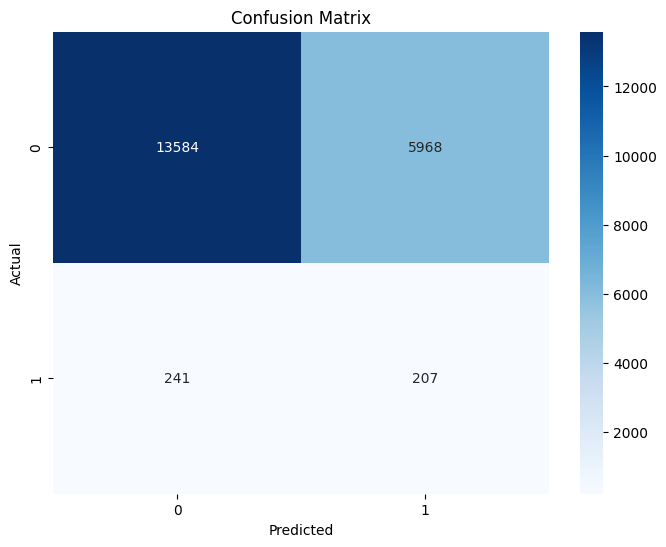

In [12]:
#==================================Part 15==============================================================
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

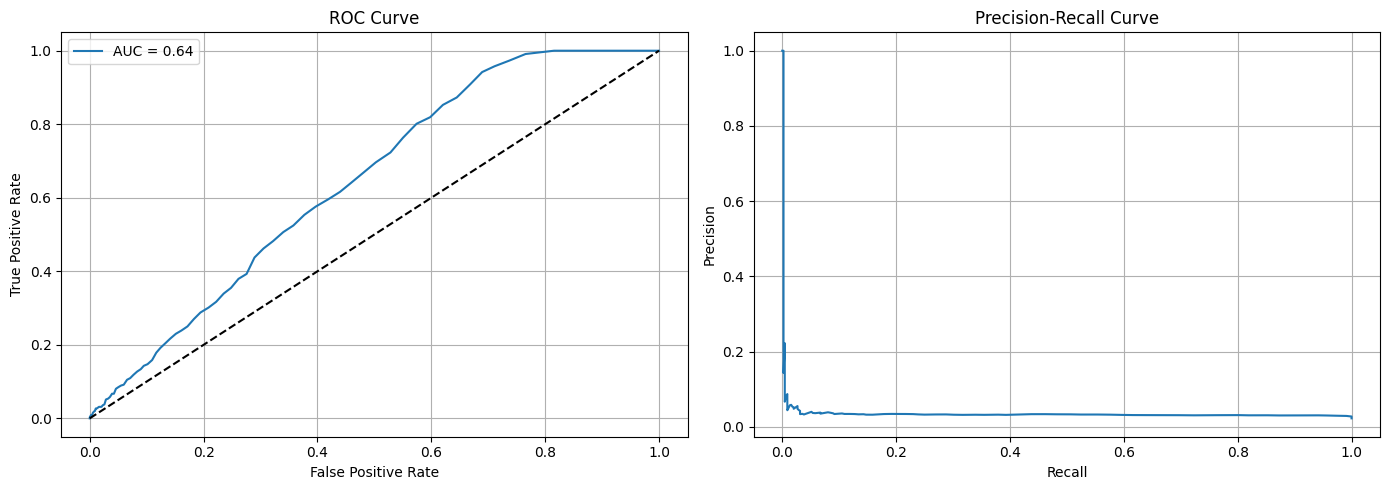

In [13]:
#==================================Part 16==============================================================
# ROC and Precision-Recall Curves

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, final_score)
axes[0].plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, final_score):.2f}")
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_title("ROC Curve")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()
axes[0].grid(True)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, final_score)
axes[1].plot(recall, precision)
axes[1].set_title("Precision-Recall Curve")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].grid(True)

plt.tight_layout()
plt.show()

Sample size for SHAP: 200
X_sample shape: (200, 10)
SHAP values shape: (200, 10, 2)


C:\Users\Saurabh\AppData\Local\Temp\ipykernel_9760\3931834324.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_reduced, X_sample)


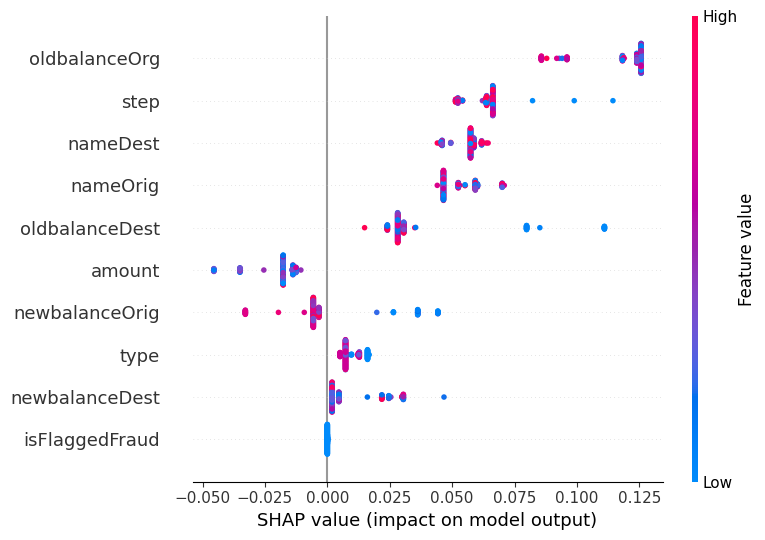

In [14]:
#==================================Part 17==============================================================
# SHAP Feature Importance Analysis

X_sample = pd.DataFrame(X_test, columns=X.columns).sample(n=min(200, len(X_test)), random_state=42)

print("Sample size for SHAP:", len(X_sample))

# Generate SHAP values
explainer = shap.TreeExplainer(rf)
shap_vals = explainer.shap_values(X_sample)

print("X_sample shape:", X_sample.shape)
print("SHAP values shape:", np.array(shap_vals).shape)

# Plot SHAP summary
shap_vals_reduced = shap_vals[:, :, 0]
shap.summary_plot(shap_vals_reduced, X_sample)